# Notebook for the compuation of the hash-based similarities

Containing methods and functionality for computing and measuring similarities from the hashes

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

from utils import file_handler as fh
from utils import metafile_handler as mfh

from schemes.grid_lsh import GridLSH
from schemes.disk_lsh import DiskLSH

from utils.similarity_measures.distance import py_edit_distance as py_ed
from utils.similarity_measures.distance import py_edit_distance_penalty as py_edp


In [4]:
PORTO_DATA = "../data/hashed_data/grid/porto//"
PORTO_META_TEST = "../data/hashed_data/grid/porto/META-50.TXT"
PORTO_META_FULL = "../data/hashed_data/grid/porto/META-1000.TXT"

def portoSet(file_size: int) -> str:
    return f"../data/chosen_data/porto/META-{file_size}.txt"


def romeSet(file_size: int) -> str:
    return f"../data/chosen_data/rome/META-{file_size}.txt"

def mirrorDiagonal(M: np.ndarray ) -> np.ndarray:
    """Flips and mirrors a two-dimenional np.array """
    return M.values + np.rot90(np.fliplr(M.values))

In [7]:
files = mfh.read_meta_file(portoSet(50))
hashes = fh.load_trajectory_hashes(files, PORTO_DATA)
print(len(hashes.keys()))

hashed_distances = py_edp(hashes)
#print(hashed_distances)

# Forenkler en korrelasjonsberegning her(Halvparten er 0)
flattened_hashed = hashed_distances.stack().values

print(hashed_distances.shape)

# Leser dtw og frechet testset:
porto_dtw = pd.read_csv("./benchmarks/similarities/porto-dtw-test.csv", index_col=0)
porto_frechet = pd.read_csv("./benchmarks/similarities/porto-frechet-test.csv", index_col=0)
p_dtw_vals = mirrorDiagonal(porto_dtw).flatten()
p_fre_vals = mirrorDiagonal(porto_frechet).flatten()

hd = mirrorDiagonal(hashed_distances).flatten()

ones = np.zeros(porto_dtw.shape)
ones[0][0] = 2
print(porto_dtw.shape)
print(ones.shape)

print("Dtw/ones: ", np.corrcoef(p_dtw_vals, ones.flatten())[0][1])
#print(p_dtw_vals)
#print(p_fre_vals)

print("Dtw/Fre: ", np.corrcoef(p_dtw_vals, p_fre_vals)[0][1])
print("Hsh/Dtw: ", np.corrcoef(hd, p_dtw_vals)[0][1])
print("Hsh/Fre: ", np.corrcoef(hd, p_fre_vals)[0][1])

#print("Ones/Fre: ", np.corrcoef(, p_fre_vals)[0][1])


50
(50, 50)
(50, 50)
(50, 50)
Dtw/ones:  -0.03716337672708054
Dtw/Fre:  0.7272283344087425
Hsh/Dtw:  0.691291950689564
Hsh/Fre:  0.6839139931563823


In [8]:
#print(porto_dtw)
print(np.corrcoef(mirrorDiagonal(porto_dtw), mirrorDiagonal(porto_frechet) ))
#print(np.corrcoef(mirrorDiagonal(porto_dtw), mirrorDiagonal(porto_frechet.values) ))


[[ 1.         -0.14625096 -0.6385485  ...  0.66343679  0.46068728
  -0.52402209]
 [-0.14625096  1.          0.6409712  ... -0.38518506  0.22211661
   0.59240726]
 [-0.6385485   0.6409712   1.         ... -0.6591125  -0.43942476
   0.58958462]
 ...
 [ 0.66343679 -0.38518506 -0.6591125  ...  1.          0.33176766
  -0.31878083]
 [ 0.46068728  0.22211661 -0.43942476 ...  0.33176766  1.
  -0.03630427]
 [-0.52402209  0.59240726  0.58958462 ... -0.31878083 -0.03630427
   1.        ]]


# Experimental cells to determine experimental number ofgrids
Starting with Grid object

In [13]:
PORTO_CHOSEN_DATA = "../data/chosen_data/porto/"
PORTO_HASHED_DATA = "../data/hashed_data/grid/porto/"
PORTO_META_TEST = "../data/hashed_data/grid/porto/META-50.TXT"

P_MAX_LON = -8.57
P_MIN_LON = -8.66
P_MAX_LAT = 41.19
P_MIN_LAT = 41.14

# True similarities:

P_dtw = pd.read_csv("./benchmarks/similarities/porto-dtw-test.csv", index_col=0) #.stack().values
P_fre = pd.read_csv("./benchmarks/similarities/porto-frechet-test.csv", index_col=0) #.stack().values
P_dtw_mirrored = mirrorDiagonal(P_dtw).flatten()
P_fre_mirrored = mirrorDiagonal(P_fre).flatten()

# Varying resolution and layers 
min_res, max_res, res_step = 0.2, 10, 0.5
min_lay, max_lay, lay_step = 2, 15, 1

results = []
for lay in range(min_lay, max_lay+1, lay_step):
    result = []
    for res in np.arange(min_res, max_res+0.05, res_step):
        print(f"L: {lay}", "{:.2f}".format(res), end="\r")
        Grid = GridLSH(f"GP_{lay}-{'{:.2f}'.format(res)}", P_MIN_LAT, P_MAX_LAT, P_MIN_LON, P_MAX_LON, res, lay, PORTO_META_TEST, PORTO_CHOSEN_DATA)
        hashes = Grid.compute_dataset_hashes()
        
        eds = py_edp(hashes)
        flattened_eds = mirrorDiagonal(eds).flatten()

        corr = np.corrcoef(flattened_eds, P_fre_mirrored)[0][1]
        #corr, p =spearmanr(flattened_eds, P_fre_mirrored)
        result.append([corr, res])
    results.append([result, lay])



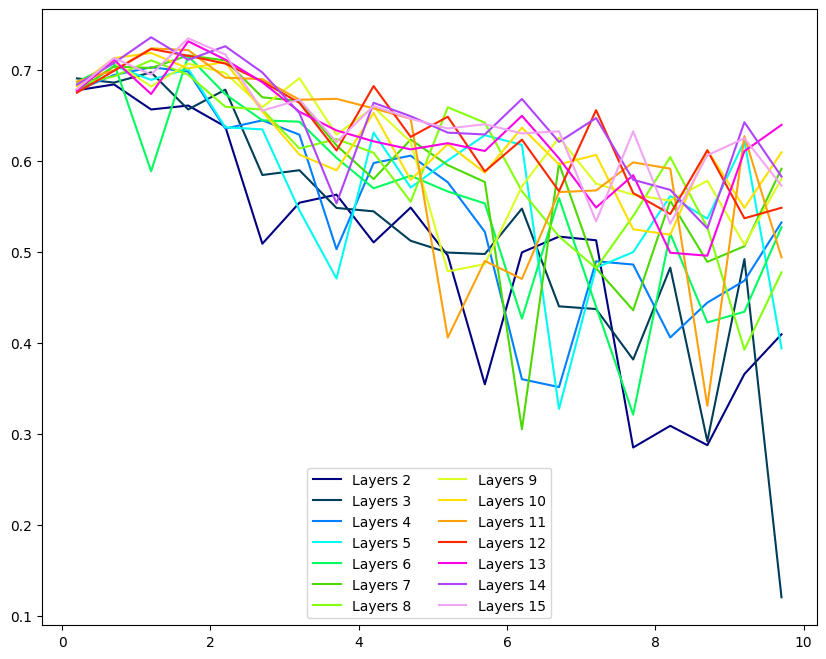

In [14]:
### Plotting the results from the last cell
if not results: raise ValueError("Cell above must be run. Results not set.")

fig = plt.figure()
fig.set_size_inches(10,8)
cmap = plt.get_cmap('gist_ncar')
N = len(results)
for resolution in results:
    corrs, layer = resolution

    
    corre, layers = list(zip(*corrs))
    plt.plot(layers, corre, c=cmap(float(layer-2)/N), label=f"Layers {layer}")
plt.legend(loc="lower center", ncols=2)
plt.show()


In [12]:
print( len(np.unique(eds)))
print(Grid)
print(hashes["P_AVX"])

190
Grid: GP_15-10.00
Covering: (5.559754011677007, 7.536733782089804) km 
Resolution: 10.0 km 
Distortion: [7.456180766774531, 1.1122496648446112, 5.694487721769638, 3.036404936130647, 1.4856808468285576, 8.445205928901254, 1.7160049356396978, 5.6064874842551795, 6.1194822968285125, 5.45630449779132, 0.40519627498471156, 1.8457168614002273, 5.7172776561718, 7.074054081192282, 4.320140102355269] km 
Dimensions: (0, 0) cells
[['AAab', 'ABab'], ['AAaa'], ['AAaa'], ['AAaa'], ['AAaa'], ['ABab', 'AAab', 'ABab'], ['AAaa'], ['AAaa'], ['AAab', 'AAaa'], ['AAaa'], ['AAaa'], ['AAaa'], ['AAaa'], ['AAab', 'AAaa'], ['AAaa']]


In [59]:
PORTO_CHOSEN_DATA = "../data/chosen_data/porto/"
PORTO_HASHED_DATA = "../data/hashed_data/disk/porto/"
PORTO_META_TEST = "../data/hashed_data/disk/porto/META-50.TXT"

P_MAX_LON = -8.57
P_MIN_LON = -8.66
P_MAX_LAT = 41.19
P_MIN_LAT = 41.14

# True similarities:

P_dtw = pd.read_csv("./benchmarks/similarities/porto-dtw-test.csv", index_col=0) #.stack().values
P_fre = pd.read_csv("./benchmarks/similarities/porto-frechet-test.csv", index_col=0) #.stack().values
P_dtw_mirrored = mirrorDiagonal(P_dtw).flatten()
P_fre_mirrored = mirrorDiagonal(P_fre).flatten()

# Varying resolution and layers 
min_lay, max_lay, lay_step = 3, 10, 1
min_dia, max_dia, dia_step = 1, 3, 0.5

results = []
for lay in range(min_lay, max_lay+1, lay_step):

    result = []
    for dia in np.arange(min_dia, max_dia+0.05, dia_step):
        print(f"L: {lay}", "{:.2f}".format(dia), end="\r")
        Disk = DiskLSH(f"GP_{lay}-{'{:.2f}'.format(dia)}", P_MIN_LAT, P_MAX_LAT, P_MIN_LON, P_MAX_LON, 50, lay, dia, PORTO_META_TEST, PORTO_CHOSEN_DATA)
        hashes = Disk.compute_dataset_hashes_with_KD_tree()
        
        eds = py_ed(hashes)
        flattened_eds = mirrorDiagonal(eds).flatten()

        corr = np.corrcoef(flattened_eds, P_fre_mirrored)[0][1]
        result.append([corr, dia])
    results.append([result, lay])

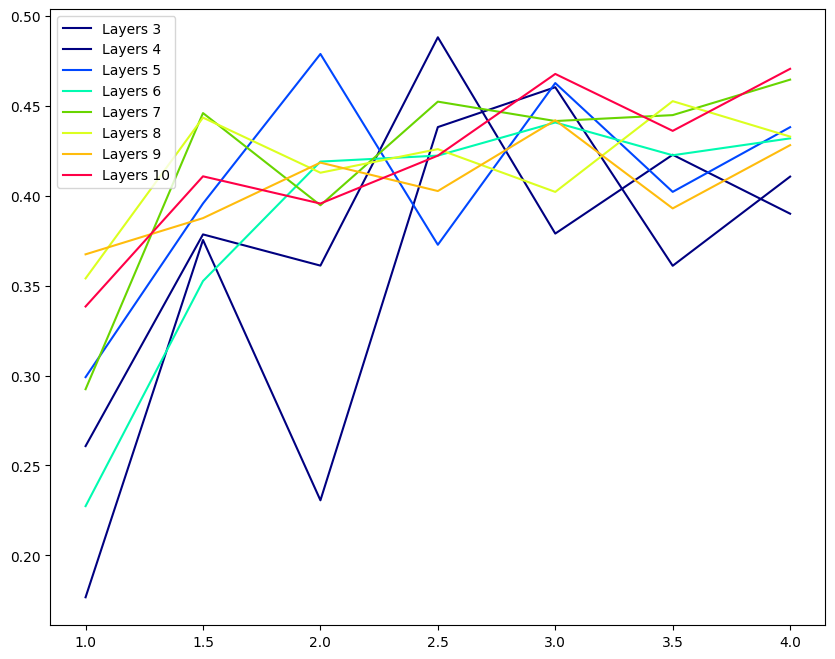

In [60]:
### Plotting the results from the last cell
if not results: raise ValueError("Cell above must be run. Results not set.")

fig = plt.figure()
fig.set_size_inches(10,8)
cmap = plt.get_cmap('gist_ncar')
N = len(results)
for resolution in results:
    corrs, layer = resolution

    
    corre, layers = list(zip(*corrs))
    plt.plot(layers, corre, c=cmap(float(layer-4)/N), label=f"Layers {layer}")
    plt.legend(loc="upper left")
plt.show()

In [61]:
print( len(np.unique(eds)))
print(Disk)
print(hashes["P_AVX"])

1226
Disk-scheme: GP_10-4.00 
Covering: (5.559754011677007, 7.536733782089804) km 
Diameter: 4.0 km
Layers: 10 

[['BV', 'AG', 'BP', 'BW', 'AP', 'AQ', 'AA', 'BI', 'AT', 'BV', 'AI', 'AR', 'BM', 'BT', 'BE', 'BH', 'BO', 'BO', 'BD', 'AC', 'AT', 'BG', 'AV', 'AL', 'BU'], ['AM', 'AZ', 'BU', 'BS', 'AF', 'BM', 'AX', 'AP', 'AR', 'AB', 'AG', 'AV', 'BD', 'BE', 'AE', 'BH', 'BE', 'AU'], ['BO', 'BB', 'BW', 'BP', 'AL', 'AB', 'AV', 'BX', 'BF', 'AK', 'AC', 'BG', 'BU', 'AS', 'BQ', 'AW', 'BD', 'AD', 'AP', 'AG', 'AG', 'AY', 'BX'], ['BP', 'AT', 'AY', 'BD', 'AD', 'AJ', 'AA', 'AX', 'BV', 'AE', 'BM', 'BU', 'BM', 'AZ', 'BG', 'AF', 'BW', 'BL', 'BA', 'AC'], ['AQ', 'BG', 'BF', 'BW', 'BV', 'BL', 'AX', 'AD', 'BS', 'AM', 'AE', 'AT'], ['AB', 'BO', 'AR', 'BQ', 'BW', 'BP', 'AM', 'BH', 'AV', 'BC', 'AG', 'AZ', 'BJ'], ['BJ', 'BL', 'BD', 'BG', 'AD', 'BU', 'BM', 'AJ', 'BB', 'AV', 'AW', 'AQ', 'BI', 'AN', 'BT', 'BM', 'AC', 'BK', 'AE', 'BS', 'AX', 'AM', 'BO', 'BT', 'BC', 'AP'], ['AJ', 'BL', 'BM', 'BQ', 'AT', 'BX', 'BA', 'AP', '

# Experimental cells for determing Rome Values


In [15]:
ROME_CHOSEN_DATA = "../data/chosen_data/rome/"
ROME_HASHED_DATA = "../data/hashed_data/grid/rome/"
ROME_META_TEST = "../data/hashed_data/grid/rome/META-50.TXT"

R_MAX_LON = 12.53
R_MIN_LON = 12.44
R_MAX_LAT = 41.93
R_MIN_LAT = 41.88

# True similarities:

P_dtw = pd.read_csv("./benchmarks/similarities/rome-dtw-test.csv", index_col=0) #.stack().values
P_fre = pd.read_csv("./benchmarks/similarities/rome-frechet-test.csv", index_col=0) #.stack().values
P_dtw_mirrored = mirrorDiagonal(P_dtw).flatten()
P_fre_mirrored = mirrorDiagonal(P_fre).flatten()

# Varying resolution and layers 
min_res, max_res, res_step = 0.2, 3, 0.2
min_lay, max_lay, lay_step = 2, 15, 1

results = []
for lay in range(min_lay, max_lay+1, lay_step):
    result = []
    for res in np.arange(min_res, max_res+0.05, res_step):
        print(f"L: {lay}", "{:.2f}".format(res), end="\r")
        Grid = GridLSH(f"GP_{lay}-{'{:.2f}'.format(res)}", R_MIN_LAT, R_MAX_LAT, R_MIN_LON, R_MAX_LON, res, lay, ROME_META_TEST, ROME_CHOSEN_DATA)
        hashes = Grid.compute_dataset_hashes()
        
        eds = py_edp(hashes)
        flattened_eds = mirrorDiagonal(eds).flatten()

        corr = np.corrcoef(flattened_eds, P_fre_mirrored)[0][1]
        #corr, p =spearmanr(flattened_eds, P_fre_mirrored)
        result.append([corr, res])
    results.append([result, lay])


KeyboardInterrupt: 

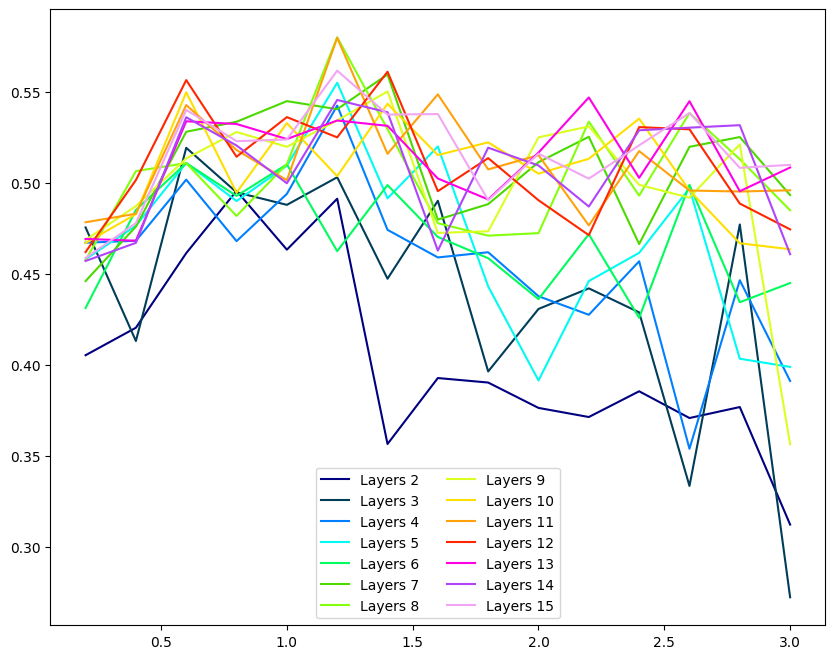

In [66]:
### Plotting the results from the last cell
if not results: raise ValueError("Cell above must be run. Results not set.")

fig = plt.figure()
fig.set_size_inches(10,8)
cmap = plt.get_cmap('gist_ncar')
N = len(results)
for resolution in results:
    corrs, layer = resolution

    
    corre, layers = list(zip(*corrs))
    plt.plot(layers, corre, c=cmap(float(layer-2)/N), label=f"Layers {layer}")
plt.legend(loc="lower center", ncols=2)
plt.show()

In [68]:
print( len(np.unique(eds)))
print(Grid)
print(hashes["R_ATG"])

1016
Grid: GP_15-3.00
Covering: (5.559754011676299, 7.451072531046803) km 
Resolution: 3.0000000000000004 km 
Distortion: [1.175211743133359, 1.6079571765237999, 2.6797275451209606, 2.7042704582268926, 0.4808292423291945, 1.4186853693415586, 0.8059244420176391, 2.453031828553247, 2.5698510970383124, 1.5837551339378362, 1.2231475336511795, 2.099308254670424, 1.5447849415467008, 0.6330228165504953, 1.992076236593971] km 
Dimensions: (1, 2) cells
[['ABaa', 'AAaa', 'ABaa', 'ABab', 'AAab', 'ABab'], ['ABaa', 'ABab'], ['ABaa', 'ABab'], ['ABaa', 'ABab'], ['AAaa', 'AAab'], ['ABaa', 'ABab'], ['AAaa', 'ABaa', 'AAaa', 'ABaa', 'AAab', 'ABab'], ['ABaa', 'ABab'], ['ABaa', 'ABab'], ['ABaa', 'ABab'], ['ABaa', 'AAaa', 'ABaa', 'ABab'], ['ABaa', 'ABab'], ['ABaa', 'ABab'], ['AAaa', 'AAab'], ['ABaa', 'ABab']]
